In [2]:
# Import libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

# Define the root directory for the dataset
ROOT = './data'

# Load the training and test datasets
train_data = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
)


In [3]:
# split training : validation = 0.9 : 0.1
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

# compute mean and std for normalization
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

# Create dataloader
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

In [4]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [5]:
# Training function
def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


# Evaluation function
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(inputs)

            # Compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [6]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 100
save_model = './model'

train_accs = []
train_losses = []
eval_accs = []
eval_losses = []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)
    
    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')
    
    # Print loss, accuracy at the end of the epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

# Load best model
lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
lenet_model.eval()


| epoch   1 |    50/  211 batches | accuracy    0.712
| epoch   1 |   100/  211 batches | accuracy    0.890
| epoch   1 |   150/  211 batches | accuracy    0.920
| epoch   1 |   200/  211 batches | accuracy    0.941
-----------------------------------------------------------
| End of epoch   1 | Time: 14.97s | Train Accuracy    0.947 | Train Loss    0.473 | Valid Accuracy    0.945 | Valid Loss    0.188
-----------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.954
| epoch   2 |   100/  211 batches | accuracy    0.959
| epoch   2 |   150/  211 batches | accuracy    0.963
| epoch   2 |   200/  211 batches | accuracy    0.967
-----------------------------------------------------------
| End of epoch   2 | Time: 14.92s | Train Accuracy    0.972 | Train Loss    0.129 | Valid Accuracy    0.972 | Valid Loss    0.094
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.972
| epoch   3 | 

C:\Users\khanh\AppData\Local\Temp\ipykernel_12632\190128675.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_

LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
# Gán phép biến đổi (transforms) cho test_data
test_data.transform = test_transforms

# Tạo DataLoader cho tập test
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

# Đánh giá mô hình trên tập test
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)

# In kết quả độ chính xác (accuracy) và mất mát (loss) trên tập test
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")


Test Accuracy: 0.986
Test Loss: 0.140


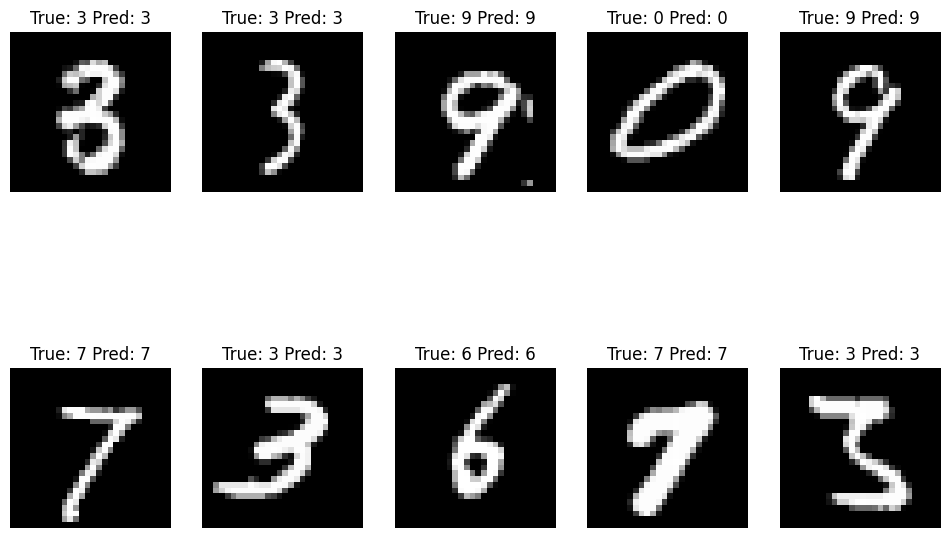

In [8]:
import random
import matplotlib.pyplot as plt

# Lấy ngẫu nhiên 10 hình ảnh từ tập test
num_samples = 10
indices = random.sample(range(len(test_data)), num_samples)
samples = torch.stack([test_data[i][0] for i in indices])  # Lấy dữ liệu hình ảnh
labels = [test_data[i][1] for i in indices]               # Lấy nhãn thực tế

# Chuyển hình ảnh sang thiết bị
samples = samples.to(device)

# Dự đoán bằng mô hình
lenet_model.eval()  # Đặt mô hình ở chế độ đánh giá (evaluation)
with torch.no_grad():  # Tắt tính toán gradient để tăng tốc
    predictions = lenet_model(samples)
    predicted_labels = predictions.argmax(1).cpu().numpy()  # Lấy nhãn dự đoán

# Vẽ hình và in ra kết quả dự đoán
plt.figure(figsize=(12, 8))
for i in range(num_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap='gray')  # Hiển thị hình ảnh
    plt.title(f"True: {labels[i]} Pred: {predicted_labels[i]}")
    plt.axis('off')
plt.show()
